>>>>> STARTING TEST with K-Means, Cluster and label as classifier and  gmm  as cutting data <<<<<
Average Accuracy:  0.62069396184
Standard Deviation:  0.134241149065
Variance:  0.0180206861022


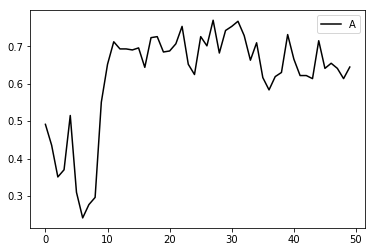

>>>>> END OF TEST <<<<<
>>>>> STARTING TEST with  kmeans  classifier <<<<<
Average Accuracy:  0.492794466909
Standard Deviation:  0.0871719523414
Variance:  0.00759894927501


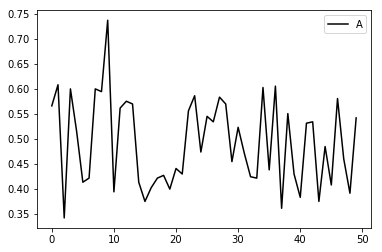

None
>>>>> END OF TEST with  kmeans  classifier <<<<<


In [1]:
import os
import pandas as pd
from testss import kmeans_svm
from testss import compose


def main():
    path = os.getcwd()+'\\data\\'
    '''
    Reading NOAA dataset:
    Eight  features  (average temperature, minimum temperature, maximum temperature, dew
    point,  sea  level  pressure,  visibility,  average wind speed, maximum  wind  speed)
    are  used  to  determine  whether  each  day  experienced  rain  or no rain.
    '''
    dataValues = pd.read_csv(path+'noaa_data.csv',sep = ",")
    dataLabels = pd.read_csv(path+'noaa_label.csv',sep = ",")
    
    #Test sets: Predicting 365 instances by step. 50 steps. Two classes.
    ''' 
    Starting labeled data with 5% of 365 instances.
    K-Means + GMM / KDE
    '''
    compose.compose(dataValues, dataLabels, 'gmm', excludingPercentage = 0.3)
    
    '''
    K-Means / SVM
    '''
    kmeans_svm.kmeans_svm(dataValues, dataLabels, 'kmeans')
    

if __name__ == "__main__":
    main()